This notebook covers a complete Data Science workflow for Insurance MegaCorp: from data exploration (EDA) to feature engineering and in-database Machine Learning using Greenplum's MADlib extension.
It uses libraries like psycopg2-binary sqlalchemy pandas matplotlib seaborn

In [2]:
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style="whitegrid")

In [3]:
# Make a connection to your Greenplum instance.
import pandas as pd
from sqlalchemy import create_engine

# 1. Connection Details
# We use 'postgres' as the default DB just to get in the door.
DB_HOST = 'big-data-001.kuhn-labs.com'
DB_PORT = '5432'       # Default port
DB_USER = 'gpadmin'               # Replace with your username
DB_PASS = 'VMware1!'  # <--- Replace with your password
TEMP_DB = 'postgres'       # Default maintenance DB

# 2. Create a temporary connection
connection_str = f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{TEMP_DB}'
engine = create_engine(connection_str)

try:
    # 3. Query the system catalog (pg_database) to find all real databases
    # We exclude templates and system DBs to make the list cleaner
    query_databases = """
    SELECT datname as database_name, 
           pg_size_pretty(pg_database_size(datname)) as size
    FROM pg_database
    WHERE datistemplate = false
    ORDER BY pg_database_size(datname) DESC;
    """
    
    # 4. Fetch and display results
    dbs_df = pd.read_sql(query_databases, engine)
    
    print("✅ Connection successful!")
    print("\nHere are the available databases on this server:")
    display(dbs_df)
    
except Exception as e:
    print("❌ Could not connect to 'postgres'. Trying 'template1'...")
    # Fallback: Sometimes 'postgres' doesn't exist, but 'template1' always does.
    try:
        fallback_str = f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/template1'
        engine_fallback = create_engine(fallback_str)
        dbs_df = pd.read_sql(query_databases, engine_fallback)
        print("✅ Connected via 'template1'!")
        display(dbs_df)
    except Exception as e2:
        print(f"❌ Critical Error: {e2}")
        print("Tip: Check your username/password or ask your admin if the port is different from 5432.")

✅ Connection successful!

Here are the available databases on this server:


,database_name,size
0,gp_assistant,416 MB
1,insurance_megacorp,130 MB
2,imc,105 MB
3,tdi,99 MB
4,insurance_megacorp_dev,99 MB


In [6]:
## Connect to database insurence_megacorp
import pandas as pd
from sqlalchemy import create_engine, text # <--- Added 'text' import

# Database Connection Parameters
DB_HOST = 'big-data-001.kuhn-labs.com'
DB_PORT = '5432'
DB_USER = 'gpadmin'
DB_PASS = 'VMware1!'
# Use 'postgres' to find other DBs, or your specific DB name if you found it
DB_NAME = 'insurance_megacorp' 

connection_str = f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(connection_str)

try:
    # Establish a connection
    with engine.connect() as connection:
        # 1. FIXED: Wrap the SQL string in text()
        result = connection.execute(text("SELECT version();"))
        print(f"✅ Connected to: {result.fetchone()[0]}")
        
        # 2. List databases (Discovery Query)
        # We use pandas read_sql with the 'engine' (not connection) for better compatibility
        query = """
        SELECT datname as database_name, 
               pg_size_pretty(pg_database_size(datname)) as size
        FROM pg_database
        WHERE datistemplate = false
        ORDER BY pg_database_size(datname) DESC;
        """
        
        print("\nChecking for available databases...")
        dbs = pd.read_sql(query, engine)
        display(dbs)

except Exception as e:
    print(f"❌ Error: {e}")

✅ Connected to: PostgreSQL 12.22 (Greenplum Database 7.5.2 build commit:3895899b5b368e7c44765a6efb12e9e815742327) on x86_64-pc-linux-gnu, compiled by gcc (GCC) 11.5.0 20240719 (Red Hat 11.5.0-5), 64-bit compiled on Jul  3 2025 02:54:28 Bhuvnesh C.

Checking for available databases...


,database_name,size
0,gp_assistant,416 MB
1,insurance_megacorp,130 MB
2,imc,105 MB
3,tdi,99 MB
4,insurance_megacorp_dev,99 MB


In [8]:
## find the available tables in the insurence_megacorp db to do analytics
try:
    # Establish a connection
    with engine.connect() as connection:
        # Check database version to verify connection
        #result = connection.execute("SELECT version();")
        #print(f"Connected to: {result.fetchone()[0]}")
        
        # List tables in the public schema
        tables_query = """
        SELECT table_name 
        FROM information_schema.tables 
        WHERE table_schema = 'public'
        ORDER BY table_name;
        """
        tables = pd.read_sql(tables_query, connection)
        print("\nAvailable Tables:")
        print(tables)

except Exception as e:
    print(f"Error connecting to database: {e}")


Available Tables:
                       table_name
0                       accidents
1          balanced_safety_scores
2                          claims
3              crash_reports_data
4                       customers
5           driver_accident_model
6   driver_accident_model_summary
7        driver_behavior_features
8         driver_ml_training_data
9       driver_safety_predictions
10                        drivers
11                       policies
12                   regr_example
13             regr_example_model
14     regr_example_model_summary
15             safe_driver_scores
16        v_current_driver_scores
17                 vehicle_events
18         vehicle_telemetry_data
19      vehicle_telemetry_data_v2
20                       vehicles


In [11]:
# Inspect the column names for 'policies' and 'vehicles'
tables_to_inspect = ['policies', 'vehicles', 'claims']

for t in tables_to_inspect:
    print(f"--- Columns in table: {t} ---")
    query = f"SELECT * FROM {t} LIMIT 0" # LIMIT 0 gets headers without loading data
    df_temp = pd.read_sql(query, engine)
    print(list(df_temp.columns))
    print("\n")

--- Columns in table: policies ---
['policy_id', 'customer_id', 'policy_number', 'start_date', 'end_date', 'status', 'created_at', 'updated_at']


--- Columns in table: vehicles ---
['vehicle_id', 'policy_id', 'vin', 'make', 'model', 'year', 'color', 'created_at', 'updated_at']


--- Columns in table: claims ---
['claim_id', 'accident_id', 'claim_date', 'status', 'amount', 'description', 'created_at', 'updated_at']




In [13]:
# Inspect 'accidents' to find the missing link
print("--- Columns in table: accidents ---")
query = "SELECT * FROM accidents LIMIT 0" 
df_accidents_schema = pd.read_sql(query, engine)
print(list(df_accidents_schema.columns))

--- Columns in table: accidents ---
['accident_id', 'policy_id', 'vehicle_id', 'driver_id', 'accident_timestamp', 'latitude', 'longitude', 'g_force', 'description', 'created_at', 'updated_at']


In [15]:
# Create a comprehensive dataset for analysis
# We use the specific columns you verified: 
# - accidents.g_force
# - vehicles.make, vehicles.model
# - claims.amount

query_master = """
SELECT 
    v.make,
    v.model,
    v.year as car_year,
    a.g_force,
    a.accident_timestamp,
    cl.amount as claim_payout,
    cl.status as claim_status
FROM claims cl
JOIN accidents a ON cl.accident_id = a.accident_id
JOIN vehicles v ON a.vehicle_id = v.vehicle_id
-- Filter for closed/paid claims to get actual costs
WHERE cl.amount IS NOT NULL
LIMIT 5000;
"""

df_master = pd.read_sql(query_master, engine)

print(f"Loaded {len(df_master)} records.")
display(df_master.head())

Loaded 7 records.


,make,model,car_year,g_force,accident_timestamp,claim_payout,claim_status
0,Chevrolet,Equinox,2023,3.1,2023-10-15 08:45:00-04:00,3250.5,APPROVED
1,Rivian,R1S,2023,7.2,2024-02-28 14:00:00-05:00,45000.0,APPROVED
2,Honda,Civic,2023,3.5,2024-03-10 20:15:00-04:00,9500.0,DENIED
3,Chevrolet,Equinox,2023,0.8,2024-03-12 09:00:00-04:00,1250.0,APPROVED
4,Hyundai,Palisade,2023,4.5,2023-12-01 12:10:00-05:00,12500.0,PENDING


/home/vcap/tmp/ipykernel_400/2954261224.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_costs, x='make', y='claim_payout', palette='viridis')


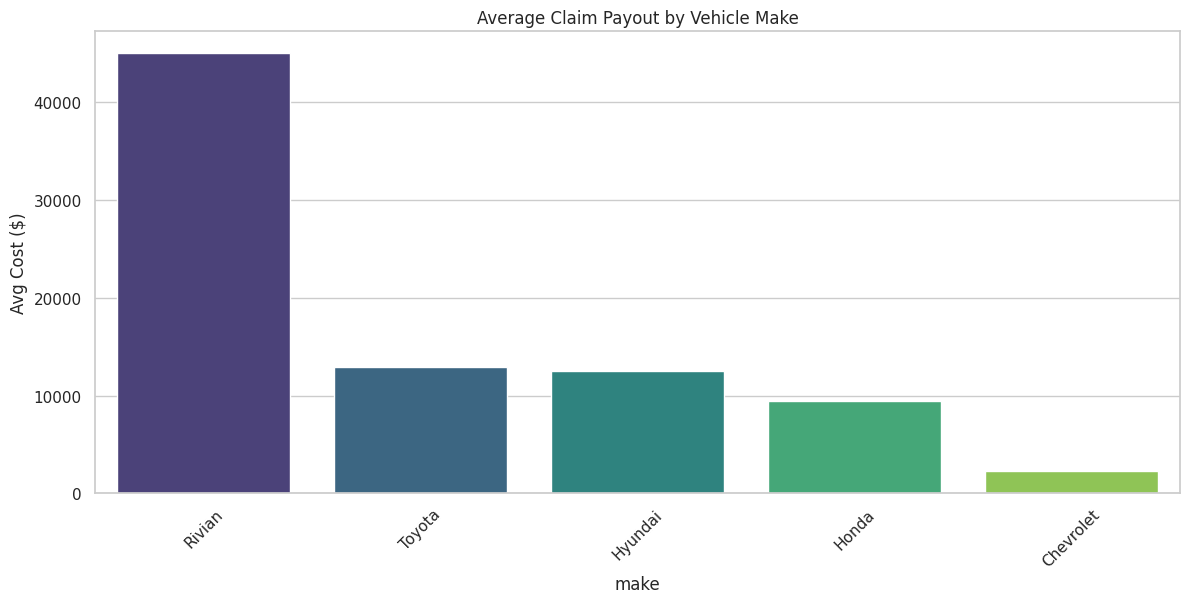

In [16]:
# Aggregating data in Pandas (since dataset is small enough after filtering)
avg_costs = df_master.groupby('make')['claim_payout'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(data=avg_costs, x='make', y='claim_payout', palette='viridis')
plt.title('Average Claim Payout by Vehicle Make')
plt.ylabel('Avg Cost ($)')
plt.xticks(rotation=45)
plt.show()

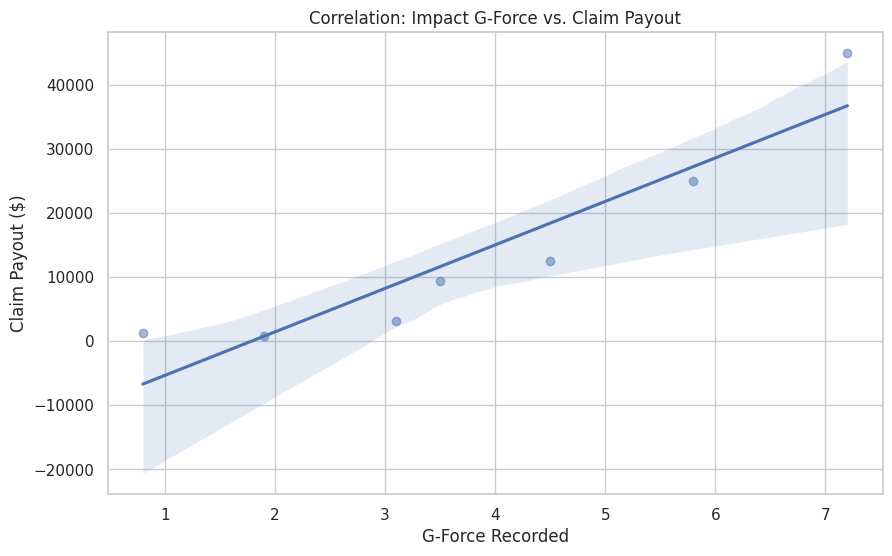

Correlation Coefficient: 0.9308


In [17]:
# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=df_master, x='g_force', y='claim_payout', scatter_kws={'alpha':0.5})
plt.title('Correlation: Impact G-Force vs. Claim Payout')
plt.xlabel('G-Force Recorded')
plt.ylabel('Claim Payout ($)')
plt.show()

# Calculate correlation coefficient
corr = df_master['g_force'].corr(df_master['claim_payout'])
print(f"Correlation Coefficient: {corr:.4f}")

In [19]:
# Updated Query: Now includes Latitude and Longitude
query_master = """
SELECT 
    v.make,
    v.model,
    v.year as car_year,
    a.g_force,
    a.accident_timestamp,
    a.latitude,   -- <--- Added
    a.longitude,  -- <--- Added
    cl.amount as claim_payout,
    cl.status as claim_status
FROM claims cl
JOIN accidents a ON cl.accident_id = a.accident_id
JOIN vehicles v ON a.vehicle_id = v.vehicle_id
WHERE cl.amount IS NOT NULL
LIMIT 5000;
"""

# Overwrite the old dataframe
df_master = pd.read_sql(query_master, engine)

print(f"Loaded {len(df_master)} records.")
display(df_master.head()) # Verify latitude/longitude are now visible

Loaded 7 records.


,make,model,car_year,g_force,accident_timestamp,latitude,longitude,claim_payout,claim_status
0,Honda,Civic,2023,3.5,2024-03-10 20:15:00-04:00,33.9580,-84.5510,9500.0,DENIED
1,Chevrolet,Equinox,2023,0.8,2024-03-12 09:00:00-04:00,33.7629,-84.4226,1250.0,APPROVED
2,Hyundai,Palisade,2023,4.5,2023-12-01 12:10:00-05:00,32.8353,-83.6362,12500.0,PENDING
3,Toyota,RAV4,2023,1.9,2023-11-20 17:30:00-05:00,32.8407,-83.6324,800.0,DENIED
4,Toyota,Highlander,2023,5.8,2024-02-05 07:50:00-05:00,33.8224,-84.3712,25000.0,PENDING


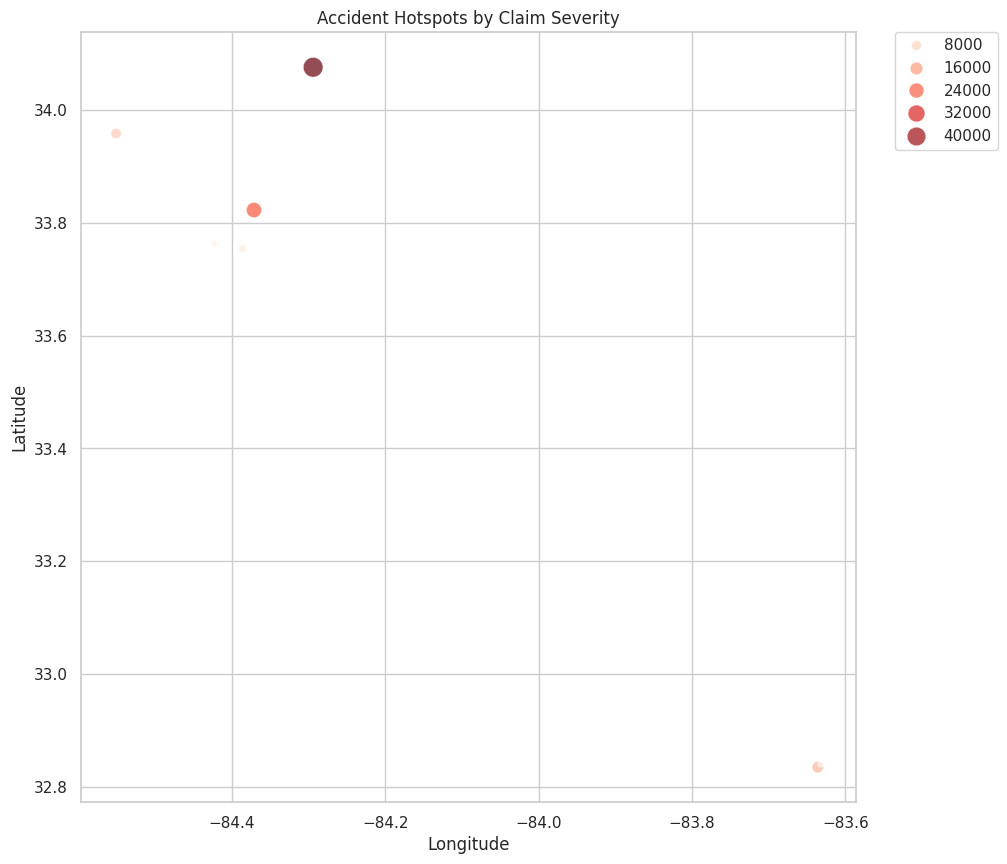

In [20]:
# Geospatial Plot
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=df_master, 
    x='longitude', 
    y='latitude', 
    hue='claim_payout', 
    size='claim_payout',
    sizes=(20, 200),
    alpha=0.7,
    palette='Reds'
)
plt.title('Accident Hotspots by Claim Severity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # Move legend outside
plt.show()